In [40]:
import tensorflowjs as tfjs
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from os.path import join
import json
import glob


In [4]:
# import os
# import tensorflow_datasets as tfds
# from PIL import Image
# print(tf.__version__)
# input_shape = (32, 32, 3)

inputFolder = "FSG_1/"

print(tf.__version__)
input_shape = (32, 32, 3)
batch_size=2

def parse_image(filename):
        """
        parse the image but apply no preprocessing
        :param filename:
        :return:
        """
        image = tf.io.read_file(filename)
        image = tf.image.decode_png(image, channels=input_shape[2])
        image = tf.image.resize(image, [input_shape[0], input_shape[1]])
        image = image / 255.
        return image

def get_ds(split_name=""):

  # load data
  paths = sorted(glob.glob(
      join(inputFolder, split_name if split_name != "" else "images", '*')))

  # load labels
  with open(join(inputFolder, '%s_labels.json' % split_name if split_name != "" else 'labels.json')) as json_file:
    labels = np.array(json.load(json_file)).astype(float) 

  list_ds = tf.data.Dataset.from_tensor_slices(paths)
  if len(paths) > 0:
      images_ds = list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
  else:
      images_ds = list_ds  # no images loadable
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)

  return images_ds, labels_ds


validation_split=0.7

input_ds, target_ds = get_ds()
ds = tf.data.Dataset.zip((
    input_ds, target_ds
            ))

train_ds_len = int(validation_split * len(input_ds))

train_ds = ds.shuffle(100).take(train_ds_len).repeat().batch(
    batch_size).prefetch(tf.data.AUTOTUNE)  # shuffle before batching
val_ds = ds.shuffle(100).skip(train_ds_len).batch(batch_size).prefetch(tf.data.AUTOTUNE)
steps_per_epoch = (train_ds_len // batch_size)

# input_ds_train, target_ds_train = get_ds('train')
# input_ds_val, target_ds_val = get_ds('val')

# train_ds = tf.data.Dataset.zip((
#                input_ds_train, target_ds_train
#            )).repeat().shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # shuffle before batching

# val_ds = tf.data.Dataset.zip((
#    input_ds_val, target_ds_val
# )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# steps_per_epoch = (len(target_ds_train) // batch_size)


print(train_ds, val_ds, "train image samples")


2.5.0
<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 5)), types: (tf.float32, tf.float64)> <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 5)), types: (tf.float32, tf.float64)> train image samples


In [ ]:
(1, 32, 32, 3)

(32, 32, 4)


In [5]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(20, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(5, activation="linear"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                4

In [6]:
def mae(y_true, y_pred):
   print(y_true, y_pred)
   difference = tf.abs(y_true - y_pred)
   return tf.reduce_mean(difference, axis=-1)

In [7]:
epochs = 15

model.compile(loss=mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
)

Epoch 1/15
Tensor("Cast:0", shape=(None, 5), dtype=float32) Tensor("sequential/dense_2/BiasAdd:0", shape=(None, 5), dtype=float32)
Tensor("Cast:0", shape=(None, 5), dtype=float32) Tensor("sequential/dense_2/BiasAdd:0", shape=(None, 5), dtype=float32)
749/749 [==============================] - 8s 7ms/step - loss: 0.1410 - val_loss: 0.1180
Epoch 2/15
749/749 [==============================] - 5s 7ms/step - loss: 0.1016 - val_loss: 0.1140
Epoch 3/15
749/749 [==============================] - 5s 7ms/step - loss: 0.0938 - val_loss: 0.0984
Epoch 4/15
749/749 [==============================] - 5s 7ms/step - loss: 0.0892 - val_loss: 0.1046
Epoch 5/15
749/749 [==============================] - 5s 7ms/step - loss: 0.0843 - val_loss: 0.1077
Epoch 6/15
749/749 [==============================] - 5s 7ms/step - loss: 0.0833 - val_loss: 0.1163
Epoch 7/15
749/749 [==============================] - 5s 7ms/step - loss: 0.0813 - val_loss: 0.1124
Epoch 8/15
749/749 [==============================] - 5s 7ms

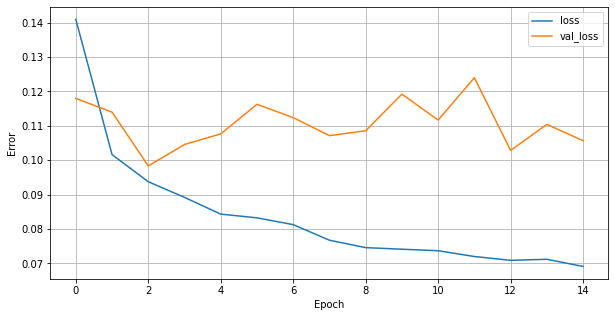

In [8]:

plt.rcParams['figure.figsize'] = [10, 5]
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)


In [9]:
score = model.evaluate(val_ds, verbose=0)
print("Test loss:", score)
#print("Test accuracy:", score[1])


Test loss: 0.10510390251874924


In [42]:
model.save('saved_model')
tfjs.converters.save_keras_model(model, "saved_model_tfjs")


INFO:tensorflow:Assets written to: saved_model\assets


In [38]:
reloaded = tf.keras.models.load_model('saved_model')
data = list(train_ds.take(1))[0][0][0].numpy()
tensor = tf.convert_to_tensor([data], dtype=tf.float32)

#print(reloaded.predict(tensor)[0])
print(reloaded.predict(tf.convert_to_tensor(
    [parse_image("Frame00265.png").numpy()], dtype=tf.float32)))


[[0.21470574 0.30604237 0.3067153  0.26683483 0.24324356]]


The last 32 images are validation images


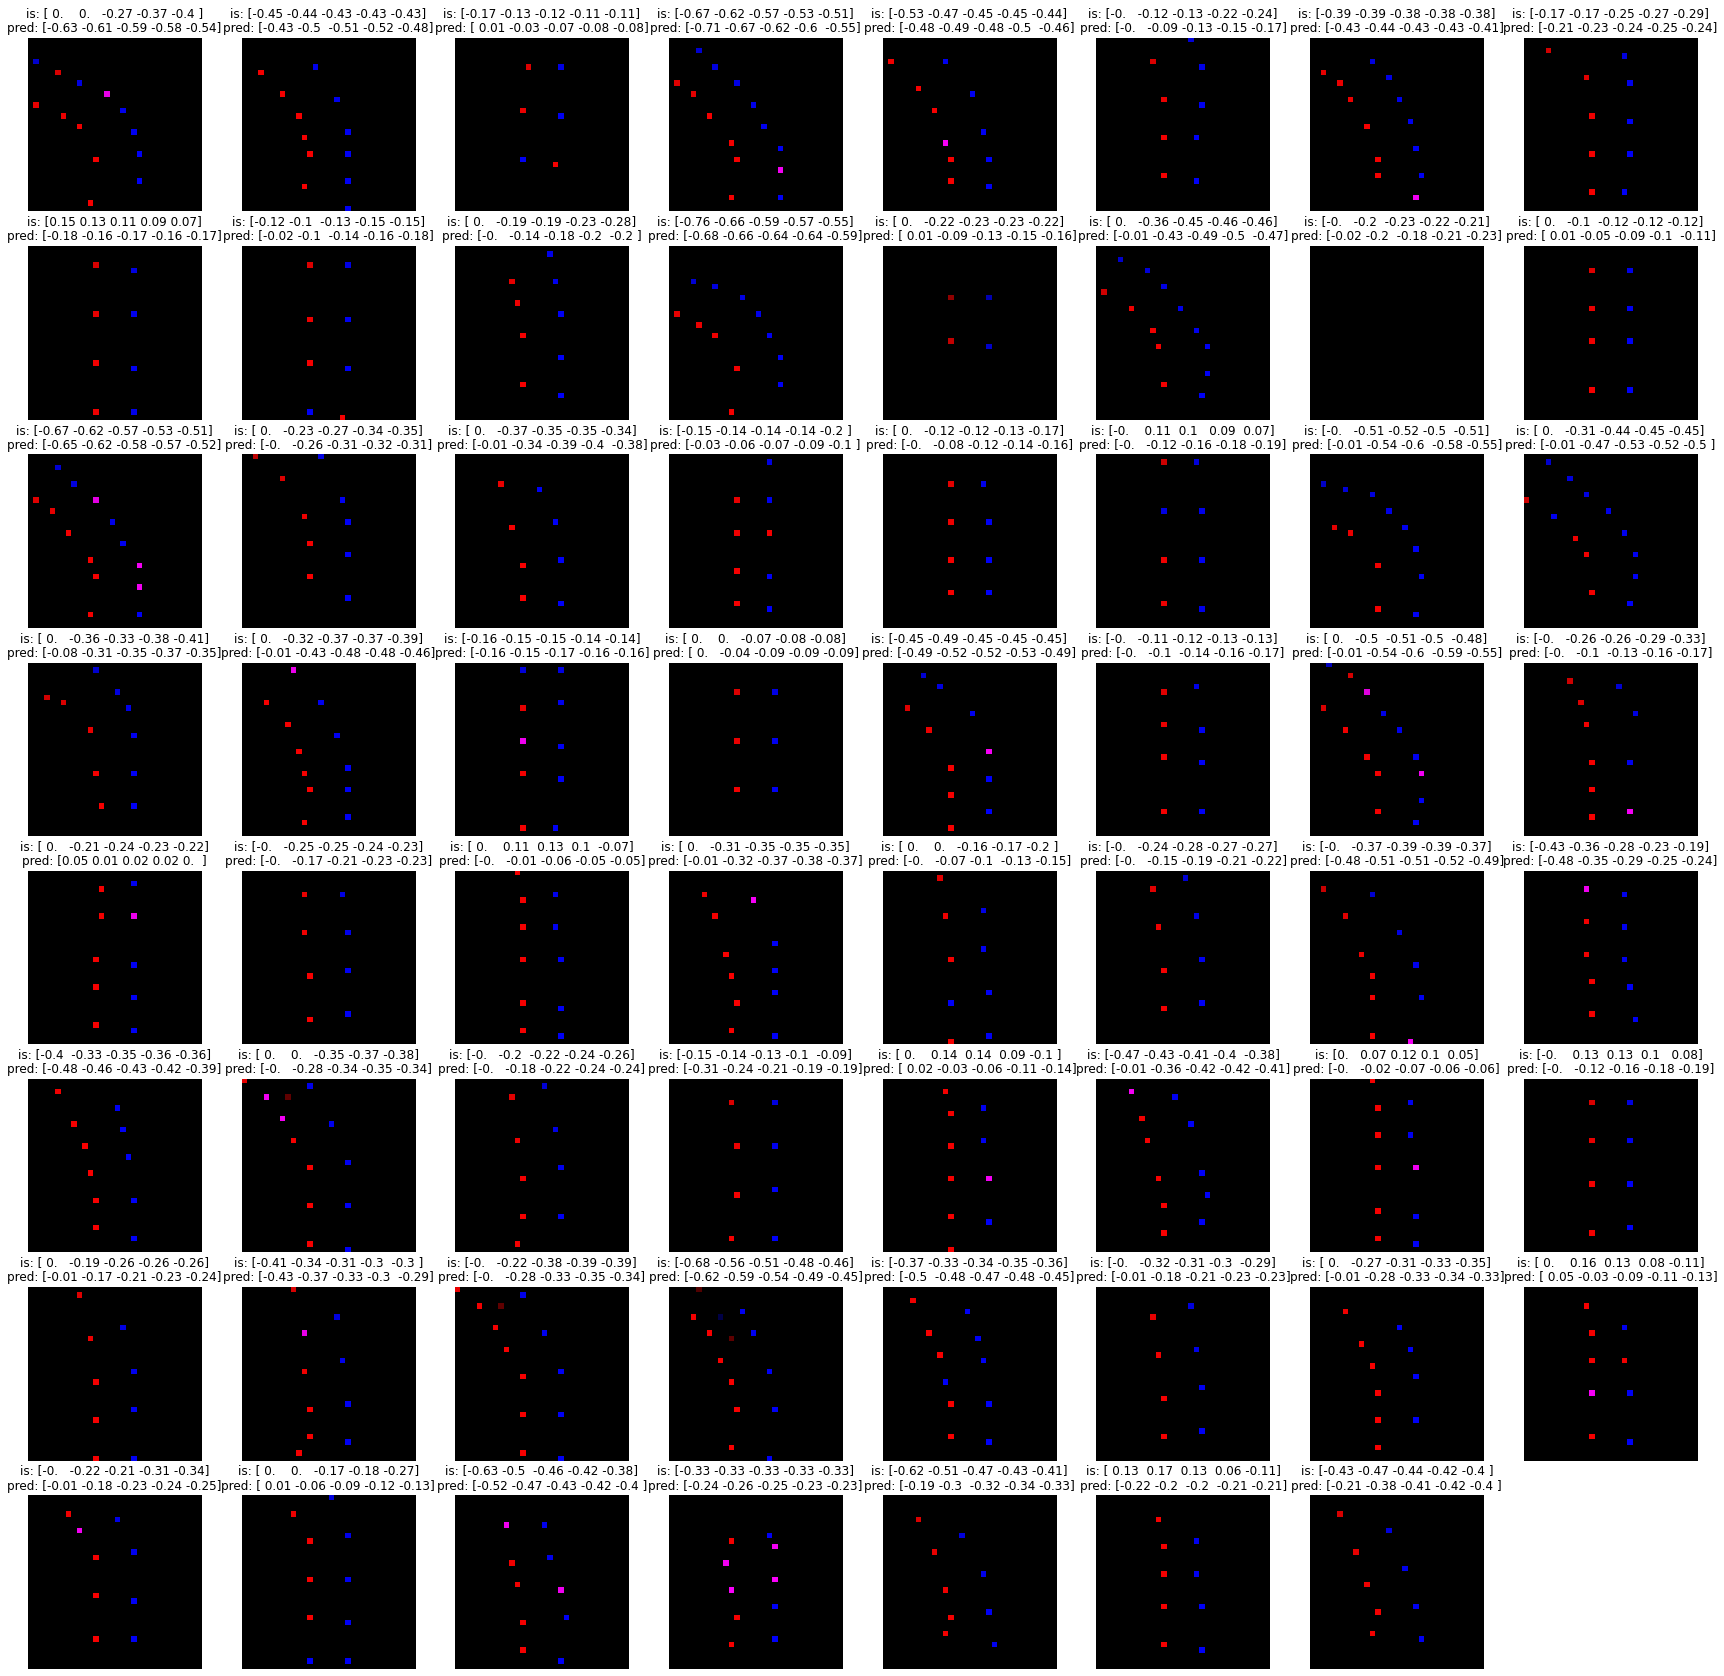

In [11]:
# plt.rcParams['figure.figsize'] = [15, 15]
# for i in range(49):
#     plt.subplot(7, 7, i+1)
#     plt.imshow(x_test[i].reshape(28, 28), cmap='gray', interpolation='none')
#     plt.axis('off')
#     plt.title("{}, is: {:.2f}".format(
#         y_test[i], model.predict(x_test[i:i+1])[0][0],2))

plt.rcParams['figure.figsize'] = [30, 30]
with np.printoptions(precision=2, suppress=True):
  for i, (images, labels) in enumerate(train_ds.shuffle(200).take(32)):
      if i == steps_per_epoch:
        print("First %d images are training images" % (steps_per_epoch * batch_size*0+32))
        break

      preds = model.predict(images)
      # print(preds.shape)
      for image, label, pred in zip(images, labels, preds):
        i=i+1
        ax = plt.subplot(8, 8, i)
        plt.imshow((image.numpy()*255).astype("uint8"))
        plt.title(
            "is: %s\npred: %s" %(label.numpy(), pred))
        plt.axis("off")

  print("The last %d images are validation images" %
        (len(val_ds) * batch_size*0+32))
  for i, (images, labels) in enumerate(val_ds.shuffle(200).take(32)):
      preds = model.predict(images)
      for image, label, pred in zip(images, labels, preds):
        ax = plt.subplot(8, 8, i+32)
        plt.imshow((image.numpy()*255).astype("uint8"))
        plt.title(
            "is: %s\npred: %s" %(label.numpy(), pred))
        plt.axis("off")
